# Домашняя работа 02
Тема: работа с табличными данными в Pandas, контроль качества данных, базовый EDA и визуализация в Matplotlib.

### Импорт библотек

In [8]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [10]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
  Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl (221 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

## Загрузка датасета

In [12]:
df = pd.read_csv('https://raw.githubusercontent.com/mirea-aie-2025/aie-course-meta/refs/heads/main/seminars/S02/S02-hw-dataset.csv')

In [13]:
df.head()

,user_id,age,country,purchases,revenue
0,1,25.0,FR,7,749
1,2,24.0,RU,5,1115
2,3,52.0,FR,7,399
3,4,31.0,RU,6,654
4,5,NaN,DE,6,1296


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB


In [15]:
df.describe()

,user_id,age,purchases,revenue
count,41.000000,39.000000,41.000000,41.000000
mean,20.243902,36.512821,4.829268,820.048780
std,11.659289,18.304259,2.710189,613.127269
min,1.000000,5.000000,-1.000000,0.000000
25%,10.000000,24.000000,3.000000,432.000000
50%,20.000000,33.000000,5.000000,693.000000
75%,30.000000,45.500000,7.000000,1115.000000
max,40.000000,120.000000,11.000000,2475.000000


## Пропуски, дубликаты и базовый контроль качества

In [17]:
# Пропуски в столбце age
missing_ratio = df.isna().mean()
missing_ratio

user_id      0.00000
age          0.04878
country      0.00000
purchases    0.00000
revenue      0.00000
dtype: float64

In [18]:
# Один дубликат
dubs = df.duplicated()
dubs.sum()

np.int64(1)

In [19]:
df[dubs]

,user_id,age,country,purchases,revenue
40,10,24.0,RU,7,511


### «Подозрительные» случаи

In [20]:
# Отрицательная покупка
neg_vals = df[(df['age'] < 0) | (df['purchases'] < 0) | (df['revenue'] < 0)]
neg_vals

,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785


In [21]:
# Нулевой доход при покупках
zero_rev = df[(df['revenue'] == 0) & (df['purchases'] > 0)]
zero_rev

,user_id,age,country,purchases,revenue
10,11,24.0,US,4,0


In [22]:
# Подозрительный возраст покупателей
sus_age = df[(df['age'] > 100) | (df['age'] < 14)]
sus_age

,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785
20,21,5.0,RU,8,1488


Проблемные сферы: полнота (не все поля заполнены, хоть их и малое кол-во), уникальность (один дубликат), валидность (найдены логические ошибки в данных, а также найдены подозрительные и нереалистичные значения).

## Базовый EDA: группировки, агрегаты и частоты

In [23]:
# Распределение по странам
country_counts = df['country'].value_counts()
country_counts

country
RU    13
FR    12
US     8
DE     6
CN     2
Name: count, dtype: int64

In [24]:
# Среднее по странам
g_cntry_mean = df.groupby('country').agg({
    'user_id': 'count',
    'age': 'mean',
    'purchases': 'mean',
    'revenue': 'mean'
}).round(2).sort_values('revenue',ascending=False)
g_cntry_mean

,user_id,age,purchases,revenue
country,,,,
DE,6,34.60,6.50,1445.50
CN,2,24.00,4.50,1054.00
RU,13,30.08,4.77,790.08
FR,12,46.25,4.25,675.92
US,8,36.71,4.62,557.38


In [25]:
# Сумма по странам
g_cntry_sum = df.groupby('country').agg({
    'user_id': 'count',
    'age': 'mean',
    'purchases': 'sum',
    'revenue': 'sum'
}).round(2).sort_values('revenue',ascending=False)
g_cntry_sum

,user_id,age,purchases,revenue
country,,,,
RU,13,30.08,62,10271
DE,6,34.60,39,8673
FR,12,46.25,51,8111
US,8,36.71,37,4459
CN,2,24.00,9,2108


In [26]:
# Средний чек
cntry_totals = df.groupby('country').agg({
    'revenue': 'sum',
    'purchases': 'sum'
})
cntry_totals['avg_revenue_per_purchase'] = cntry_totals['revenue'] / cntry_totals['purchases']

cntry_totals.round(2)

,revenue,purchases,avg_revenue_per_purchase
country,,,
CN,2108,9,234.22
DE,8673,39,222.38
FR,8111,51,159.04
RU,10271,62,165.66
US,4459,37,120.51


In [27]:
# Создание возрастных групп
age_bins = [18, 25, 35, 45, 60]
age_labels = ['18-25', '26-35', '36-45', '46-60']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)
df.head()

,user_id,age,country,purchases,revenue,age_group
0,1,25.0,FR,7,749,26-35
1,2,24.0,RU,5,1115,18-25
2,3,52.0,FR,7,399,46-60
3,4,31.0,RU,6,654,26-35
4,5,NaN,DE,6,1296,NaN


In [28]:
# Кол-во пользователей по возрастным группам
age_g_count = df['age_group'].value_counts().sort_index()
age_g_count

age_group
18-25    10
26-35    10
36-45     7
46-60    10
Name: count, dtype: int64

In [29]:
# Статистика по возрастным группам
age_g_stats = df.groupby('age_group').agg({
    'user_id': 'count',
    'age': ['mean'],
    'purchases': ['sum', 'mean'],
    'revenue': ['sum', 'mean']
}).round(2).reset_index()
age_g_stats

C:\Users\Admin\AppData\Local\Temp\ipykernel_33064\1872808420.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_g_stats = df.groupby('age_group').agg({


age_group user_id    age purchases      revenue         
              count   mean       sum mean     sum     mean
0     18-25      10  22.40        47  4.7    6171   617.10
1     26-35      10  30.00        53  5.3   10096  1009.60
2     36-45       7  38.43        35  5.0    7300  1042.86
3     46-60      10  50.60        41  4.1    5856   585.60

**Вывод:**

Топ-3 страны по кол-ву: Россия, Франция, США.

Результаты анализа дохода и кол-ва покупок по странам значительно различаются. В среднем, больше всего покупок и дохода приходится на Германию. Однако в сумме больше всего дохода приносит Россия (т.к. она больше всего представлена в датасете). Самые дорогие покупки (средний чек) приходятся на Китай.

Пользователей возрастом от 36 до 45 меньше всего в датасете.

В среднем, люди возрастом от 26 до 35 приносят наибольший доход (максимум и покупок, и выручки). Меньше всего дохода приносят люди возрастом от 46 до 60 лет.

## Визуализация данных в Matplotlib
Визуализация анализа, представленного выше.

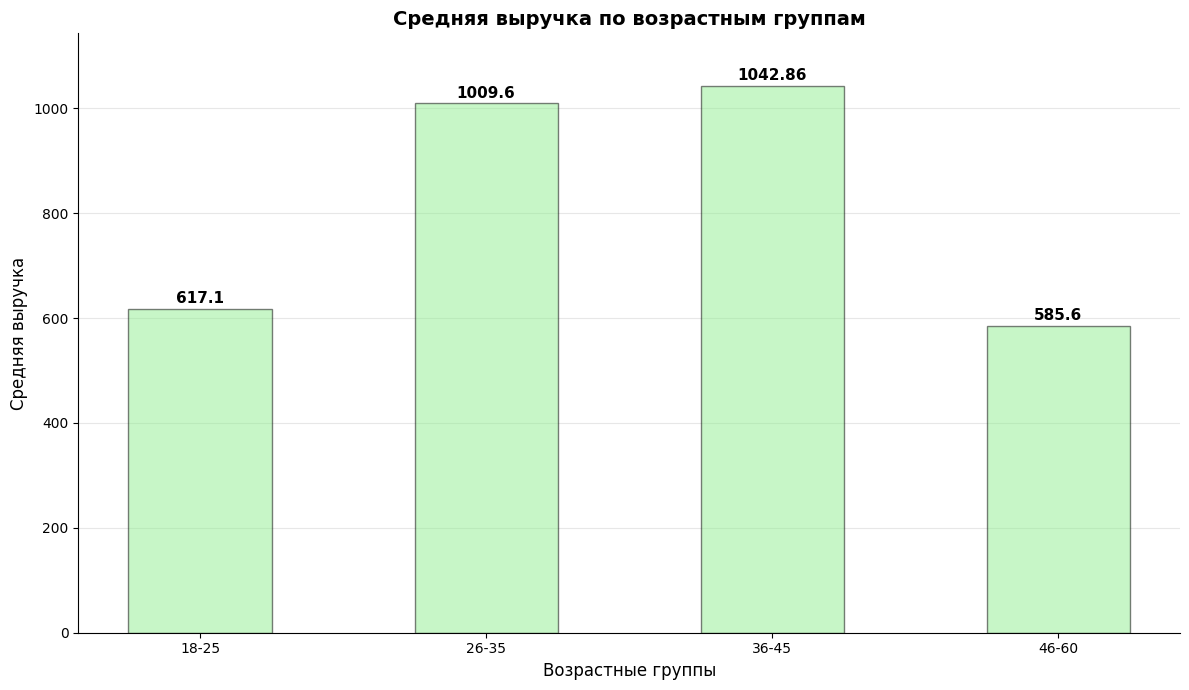

In [52]:
# Гистограмма для визуализации средней выручки по возрастным группам

age_g_stats.columns = ['age_group', 'user_count', 'age_mean', 'purchases_sum', 'purchases_mean', 'revenue_sum', 'revenue_mean']

plt.figure(figsize=(12, 7))

plt.bar(age_g_stats['age_group'], age_g_stats['revenue_mean'],
        color='lightgreen', alpha=0.5, edgecolor='black', width=0.5)

plt.xlabel('Возрастные группы', fontsize=12)
plt.ylabel('Средняя выручка', fontsize=12)
plt.title('Средняя выручка по возрастным группам', fontsize=14, fontweight='bold')

for i, value in enumerate(age_g_stats['revenue_mean']):
    plt.text(i, value + 5, f'{value}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(age_g_stats['revenue_mean']) + 100)
plt.gca().set_axisbelow(True)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig(f'figures/hist_rev_by_ageG.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

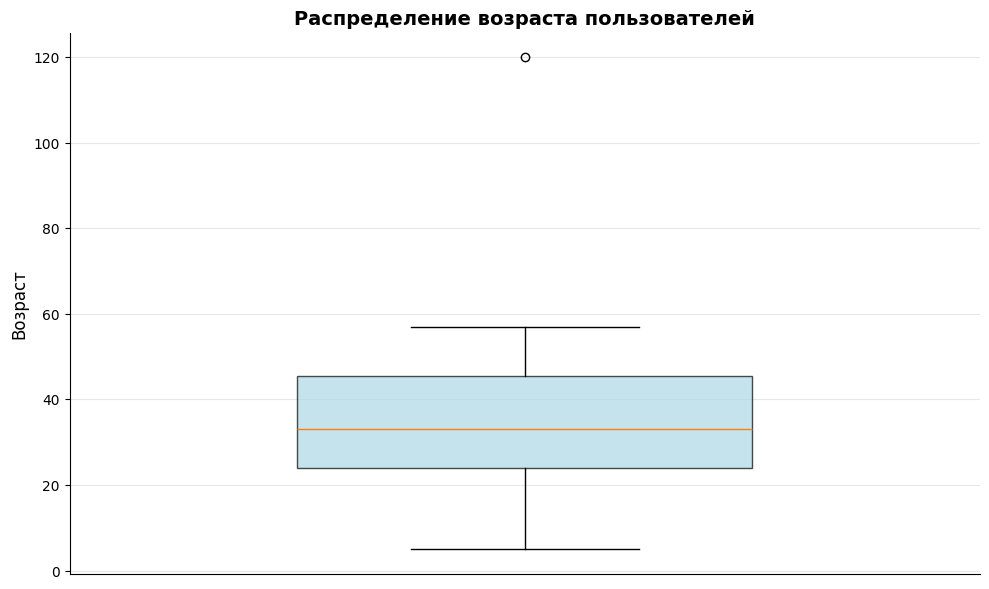

In [51]:
# Боксплот для визуализации распределения возраста пользователей

fig, ax = plt.subplots(figsize=(10, 6))

box_plot = ax.boxplot(df['age'].dropna().values,
                     vert=True,
                     patch_artist=True,
                     widths=0.5)

box_plot['boxes'][0].set_facecolor('lightblue')
box_plot['boxes'][0].set_alpha(0.7)

ax.set_ylabel('Возраст', fontsize=12)
ax.set_title('Распределение возраста пользователей', fontsize=14, fontweight='bold')
ax.set_xticks([])

ax.grid(axis='y', alpha=0.3)
ax.set_axisbelow(True)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.savefig(f'figures/bxplt_age.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

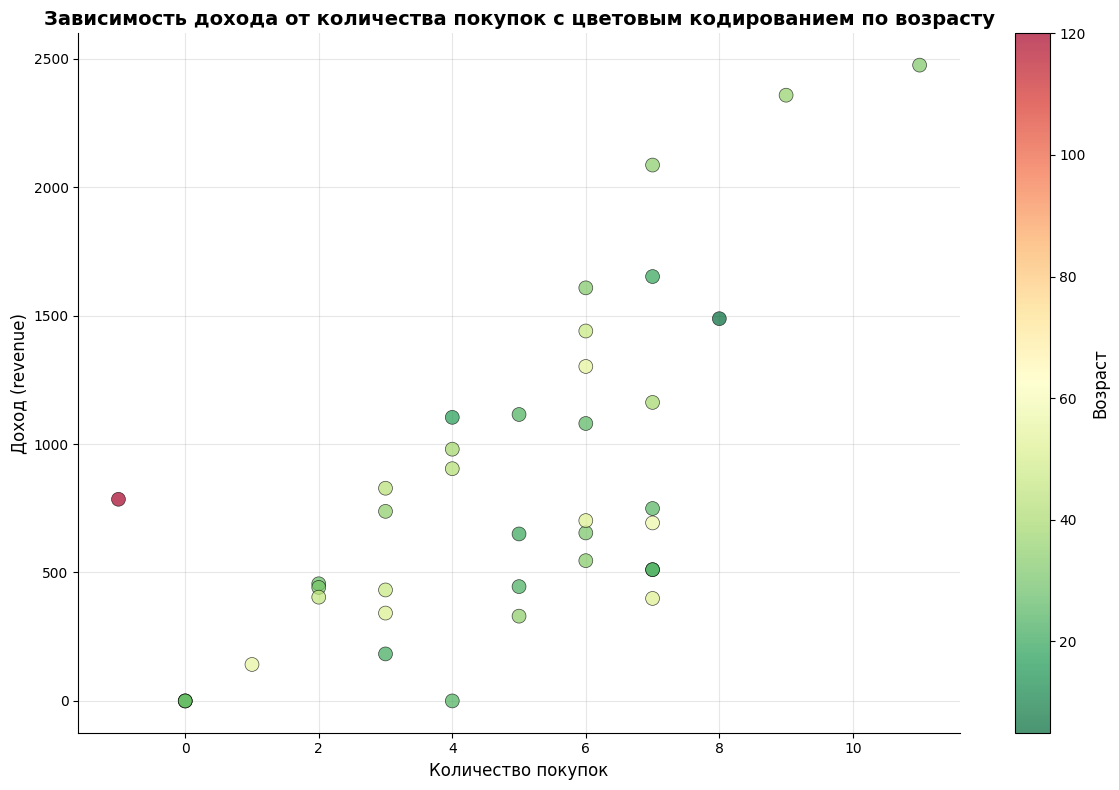

In [50]:
# Диаграмма рассеивания для визуализации корреляции дохода и количества покупок, а также возраста покупателей

plt.figure(figsize=(12, 8))

scatter = plt.scatter(x=df['purchases'],
                     y=df['revenue'],
                     c=df['age'],
                     cmap='RdYlGn_r',
                     alpha=0.7,
                     s=100,  # размер точек
                     edgecolor='black',
                     linewidth=0.5)

plt.xlabel('Количество покупок', fontsize=12)
plt.ylabel('Доход (revenue)', fontsize=12)
plt.title('Зависимость дохода от количества покупок с цветовым кодированием по возрасту',
          fontsize=14, fontweight='bold')

cbar = plt.colorbar(scatter)
cbar.set_label('Возраст', fontsize=12)

plt.grid(True, alpha=0.3)
plt.gca().set_axisbelow(True)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig(f'figures/sc_plt_rev_vs_pur_with_age.png', bbox_inches='tight')

plt.tight_layout()
plt.show()